In [1]:
#imports!
import pickle
import numpy as np
import utils
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import plot_partial_dependence, permutation_importance
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import plot_confusion_matrix, classification_report, precision_recall_fscore_support
from joblib import dump, load
%load_ext autoreload
%autoreload 2
print("we workin'!")

we workin'!


In [2]:
def varimax(Phi, gamma = 1, q = 20, tol = 1e-6):
    """Varimax is for Rotated Principal Component Analysis. Given a matrix (of loadings) Phi, 
    find an expression of the subspace spanned by Phi that maximizes the variance of the squared loadings.
    Basically rotate Phi so that there are a lot of zero weights and it's easier to understand.
    """
    from numpy import eye, asarray, dot, sum, diag
    from numpy.linalg import svd
    p,k = Phi.shape
    R = eye(k)
    d=0
    for i in range(q):
        d_old = d
        Lambda = dot(Phi, R)
        u,s,vh = svd(dot(Phi.T,asarray(Lambda)**3 - (gamma/p) * dot(Lambda, diag(diag(dot(Lambda.T,Lambda))))))
        R = dot(u,vh)
        d = sum(s)
        if d/d_old < tol: 
            print(i) 
            break
    return dot(Phi, R), R

def show_matrix(mat, ax=None, **kwargs):
    """Convenience function for plotting a matrix"""
    if not 'cmap' in kwargs.keys():
        kwargs['cmap']= plt.cm.bwr
    if not ax:
        fig, ax = plt.subplots(figsize=(8,8))
    else:
        fig = ax.figure
    ax.matshow(mat.T, **kwargs)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            c = mat[i,j]
            ax.text(i, j, f'{c:0.2f}', va='center', ha='center')
    return fig, ax
    
    
def show_loadings(loadings, yticks=None, ax=None, **kwargs):
    """Convenience function for plotting a loading, just matrix with labeled ticks"""
    fig, ax = show_matrix(loadings, ax=ax,**kwargs)
    ax.set_xticks(range(loadings.shape[0]))
    ax.set_xticklabels([f'PC{i+1}' for i in range(loadings.shape[0])])
    if yticks:
        ax.set_yticks(range(len(yticks)))
        ax.set_yticklabels(yticks)
    return ax
print('functions are a go!')

functions are a go!


# Part 1: Data preprocessing: Train/Val split, normalization, PCA and rotation

In [3]:
# initial loading of all train/validation data. Not loading any test data as this notebook is for model development and tuning.
all_sep_df = pd.DataFrame()
for year in ['2014', '2015']:#, '2016']:
    savefile = f'/home/disk/eos4/jkcm/Data/MEASURES/beta_data/classified_df_final.SEP_{year}_4.pickle'
    temp_df = pickle.load(open(savefile, 'rb'))
    all_sep_df = pd.concat([all_sep_df, temp_df], ignore_index=True)
    
    
labels={0: 'Closed-cellular MCC', 1: 'Clustered cumulus', 2: 'Disorganized MCC',
        3: 'Open-cellular MCC', 4: 'Solid Stratus', 5: 'Suppressed Cu'}
ordering = [4, 0, 2, 3, 1, 5]
short_labels = {0: 'Closed MCC ', 1: 'Clust. Cu', 2: 'Disorg. MCC',
        3: 'Open MCC', 4: 'Solid St', 5: 'Supp. Cu'}


vars_to_use = ['MERRA2_sfc_div', 'MERRA2_div_700', 'MERRA2_SST', 'MERRA2_EIS', 'MERRA2_LTS', 'MERRA2_RH_700', 
               'MERRA2_WSPD_10M', 'MERRA2_PS', 'MERRA2_TQV', 'MERRA2_T2M', 'MERRA2_M', 'MERRA2_T_adv', 'MERRA2_T_700']  # these are the variables to train on
var_labels = ['Sfc. div.', '700mb div', 'SST', 'EIS', 'LTS', '700mb RH', '10m wspd.' ,'Sfc. pres.', 'Col. Q$_V$', '2m T', 'MCAO idx', 'T$_{adv}$', '700mb T',]

# vars_to_use.append('amsr_tb_rate')
# var_labels.append('prcp. rate')

# vars_to_use.remove('MERRA2_sfc_div')
# vars_to_use.remove('Sfc. div.')

train_subset = all_sep_df[vars_to_use + ['low_cf', 'cat', 'lat', 'lon', 'cert']].copy()  # including two different y variables.

#If  only making a model to fit e.g. Clustered and Suppressed categories, set subset_categories to [1, 5]
subset_categories = False#[0,2,3]
if subset_categories:
    train_subset = train_subset[[i in subset_categories for i in train_subset['cat']]]
    labels = {k: v for k, v in labels.items() if k in subset_categories}

    

#Test Data
    
test_df = pickle.load(open(f'/home/disk/eos4/jkcm/Data/MEASURES/beta_data/classified_df_final.SEP_2016_4.pickle', 'rb'))
test_subset = test_df[vars_to_use + ['low_cf', 'cat', 'lat', 'lon', 'cert', 'season']].copy()


#filtering
cert_thresh=None;#0.999
if cert_thresh:
    for subset in [train_subset, test_subset]:
        subset.loc[subset.cert<cert_thresh, 'cert'] = np.nan
        print(f'dropping {np.sum(np.isnan(subset.cert))/len(subset):%} of the data')
        
for subset in [train_subset, test_subset]:
    # MERRA2_T_adv (*86400) should be ~-5 to 5 K/day or so, removing rows with abs(T_adv)>5 k/day.
    subset.loc[np.abs(subset['MERRA2_T_adv'].values*86400)>5, 'MERRA2_T_adv'] = np.nan

train_subset = train_subset.dropna(axis='index')  # removing any row with with a missing value
test_subset = test_subset.dropna(axis='index')  # removing any row with with a missing value

/home/disk/p/jkcm/anaconda3/envs/classified-cset/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


In [4]:
# Split the data into training and validation sets - since we have a separate test set, we can look at these all we want.
x_data = train_subset[vars_to_use].values.copy()
y_data = train_subset['low_cf'].values.copy()
strat_data = train_subset['cat'].values.copy()  # this is the stratification variable - lets make sure we have the right amount of each category in both datasets.
train_features, val_features, train_labels, val_labels, train_cats, val_cats = train_test_split(
    x_data, y_data, strat_data, test_size = 0.25, random_state = 45, stratify=strat_data)

In [5]:
# Scale the data using the StandardScaler class. Note that we fit the scaler only on the train features.
# This scaling is part of the model, and this same scaling must be applied to all test data 
# without any more refitting.
x_scaler = StandardScaler().fit(train_features)
x_train = x_scaler.transform(train_features)
x_val = x_scaler.transform(val_features)
x_all = x_scaler.transform(x_data)

test_data = test_subset[vars_to_use].values.copy()
x_test = x_scaler.transform(test_data)
test_cats = test_subset['cat'].values.copy()
test_labels = test_subset['low_cf'].values.copy()

In [6]:
# bin by hexile of train_cf, can safely be ignored usually
pctiles = [np.percentile(train_labels,i) for i in np.arange(0,100,100/6)][::-1]
train_cats_cf = 5-np.argmax(np.subtract(train_labels[:,None], pctiles)>0, axis=1)
val_cats_cf = 5-np.argmax(np.subtract(val_labels[:,None], pctiles)>0, axis=1)
test_cats_cf = 5-np.argmax(np.subtract(test_labels[:,None], pctiles)>0, axis=1)

In [7]:
# Performing Principal Component Analysis on the training data, to reduce correlations. 
# The numpy pca functions we insufficiently flexible so they are rewritten here
# after this, rot_norm_pcs is our new x_train, and rot_norm_pcs_test is our new x_test.
n, p = x_train.shape
k = 8   # this is the # of PC's to keep if doing truncated PCA
U, S_a_all, Vt= np.linalg.svd(x_train, full_matrices=False)
#let's flip some signs
for i,v in enumerate(Vt):
    if np.sign(v[np.argmax(np.abs(v))])==-1:
        Vt[i] = -Vt[i]
        U[:,i] = -U[:,i]
if k<p:
    U=U[:,:k]
    S_a = S_a_all[:k]
    Vt = Vt[:k,:]
else: 
    S_a = S_a_all
pct_var = S_a_all**2/np.sum(S_a_all**2)
cum_var = np.cumsum(pct_var)

V = Vt.T
S = np.diag(S_a)
recon_x = np.dot(np.dot(U, S), Vt)
norm_pcs = np.sqrt(n-1)*U
loadings = np.dot(V,S)/np.sqrt(n-1)
rot_loadings, R = varimax(loadings)
rot_norm_pcs = np.dot(norm_pcs, R) # x_train~ = np.dot(rot_norm_pcs, rot_loadings.T)
pct_var_rot = np.sum(rot_loadings**2, axis=0)/np.sum(rot_loadings**2)

rot_norm_pcs_val = np.matmul(x_val, np.linalg.pinv(rot_loadings.T))
rot_norm_pcs_all = np.matmul(x_all, np.linalg.pinv(rot_loadings.T))

rot_norm_pcs_test = np.matmul(x_test, np.linalg.pinv(rot_loadings.T))

/home/disk/p/jkcm/anaconda3/envs/classified-cset/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


In [8]:
X_ish = x_scaler.inverse_transform(np.matmul(rot_norm_pcs_all, rot_loadings.T))

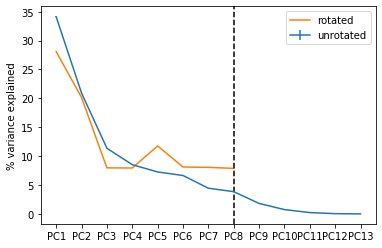

In [9]:
# Plotting the variance explained by the PCs, as well as the rotated PCs
pct_var_errbars = pct_var*100 * np.sqrt(2/n)

fig, ax = plt.subplots()
ax.errorbar(x=range(p), y=pct_var*100, yerr=pct_var_errbars, label='unrotated')
ax.plot(pct_var_rot*100, label='rotated')
ax.set_xticks(range(p))
ax.set_xticklabels([f'PC{i+1}' for i in range(p)])
ax.axvline(8-1, c='k', ls='--')
ax.legend()
ax.set_ylabel("% variance explained");
# fig.savefig('/home/disk/p/jkcm/plots/defense/ch3_percent_variance.png', bbox_inches='tight')

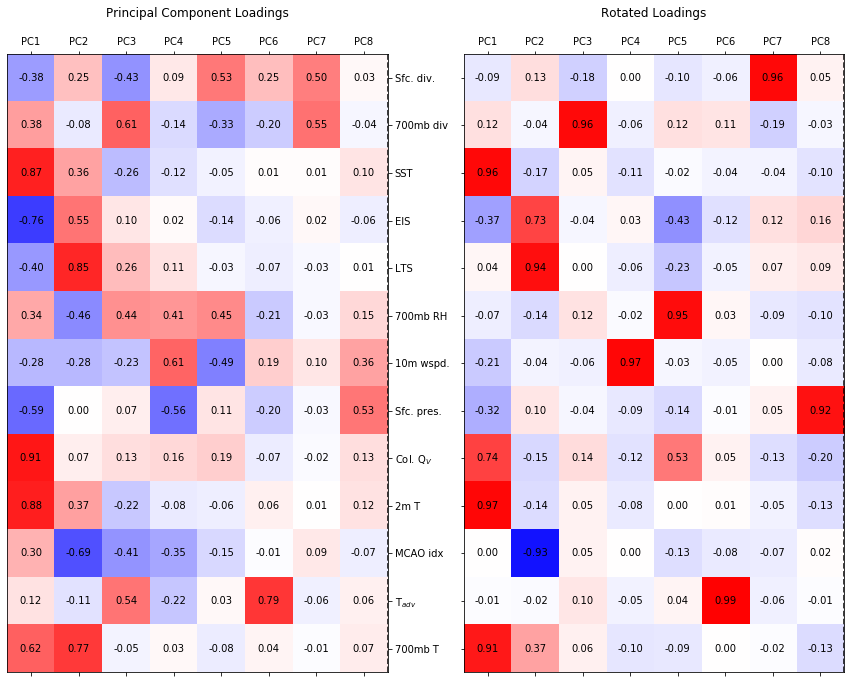

In [10]:
# Plotting Loadings from PC
fig, (ax1, ax2) = plt.subplots(figsize=(15,15), ncols=2, sharey=True)
show_loadings(loadings.T, var_labels, ax=ax1, vmin=-1, vmax=1)
show_loadings(rot_loadings.T, var_labels, ax=ax2, vmin=-1, vmax=1)
ax1.set_title('Principal Component Loadings')
ax1.axvline(8-0.5, c='k', ls='--')
ax2.axvline(8-0.5, c='k', ls='--')
ax2.set_title('Rotated Loadings')
ax1.yaxis.tick_right()
fig.subplots_adjust(wspace=0.20)
# fig.savefig('/home/disk/p/jkcm/plots/defense/ch3_loadings.png', bbox_inches='tight')

In [11]:
# data_dict = dict(
#     x_train = rot_norm_pcs,
#     y_train = train_cats,
#     y_train_cf = train_labels,
#     x_val = rot_norm_pcs_val,
#     y_val = val_cats,
#     y_val_cf = val_labels,
#     x_all = rot_norm_pcs_all,
#     y_all = strat_data,
#     y_all_cf = y_data,
#     loadings = rot_loadings,
#     scaler = x_scaler,
#     var_names = vars_to_use)

# with open('/home/disk/eos4/jkcm/Data/MEASURES/classified_data/PCA_data.pickle' ,'wb') as f:
#     pickle.dump(data_dict, f)

# Part 2: Model Training, tuning, and basic evaluation

Just to set expectactions, what would a totally crap ML model do? Well, for balanced binary classification, it would just flip a coin, so it would be right half the time. What about for unbalanced binary classification? Let's say the dataset was 25% blue, 75% red? Well the model could be 75% right if it just guessed 'red' all the time, but let's say it's trying its best with no information. In that case it would guess blue 25% and red 75%, and so be correct (.25*.25 + .75*.75=)62.5% of the time. Actually worse than 'just guess the most often', but a more honest baseline. This would also do a better job minimizing variance in per-category scores. So let's use this as our baseline for our model, where the 'worse-case' performance is either 1) frequency of most common type (in our case 32% for supp), but then it's 100% wrong on the other cats, or each cat's score is it's freq, and the overall score in the sum of squared frequencies. Alternatively, if weighted 

In [12]:
def eval_model(model, x_eval, y_eval, labels=labels, ordering=ordering):
    for i in ordering:
        arr = y_eval==i
        x_eval_i = x_eval[arr]
        y_eval_i = y_eval[arr]
        sc = model.score(x_eval_i, y_eval_i)
        freq_of_type = np.sum(arr)/len(arr)
        print(f'score for {labels[i]} ({freq_of_type:0.0%}):      {sc:0.0%}')

    sc = model.score(x_eval, y_eval)
    print(f'\nOverall score:      {sc:0.0%}')
    
def eval_with_topx(model, x_eval, y_eval, labels=labels, ordering=ordering):
    for i in ordering:
        arr = y_eval==i
        x_eval_i = x_eval[arr]
        y_eval_i = y_eval[arr]
#         sc = model.score(x_eval_i, y_eval_i)
        probs = rf.predict_proba(x_eval_i)
        best_n = np.argsort(probs, axis=1)[:,-2:]
        

        freq_of_type = np.sum(arr)/len(arr)
        print(f'score for {labels[i]} ({freq_of_type:0.0%}):      {sc:0.0%}')

#     sc = model.score(x_eval, y_eval)
    probs = rf.predict_proba(rot_norm_pcs_test)
    best_n = np.argsort(probs, axis=1)[:,-2:]

    print(f'\nOverall score:      {sc:0.0%}')
    
                   
def test_model(model):
    eval_model(model, x_eval=rot_norm_pcs_test, y_eval=test_cats)
    
def validate_model(model):
    eval_model(model, x_eval=rot_norm_pcs_val, y_eval=val_cats)

In [13]:
# baseline score
tot = 0
for i in np.unique(val_cats):
    arr = val_cats==i
    freq_of_type = np.sum(arr)/len(arr)
    print(f'baseline score for {labels[i]}: {freq_of_type:0.0%}')
    tot += freq_of_type**2
print(f'\n baseline Overall score: {tot:0.0%}')


baseline score for Closed-cellular MCC: 12%
baseline score for Clustered cumulus: 32%
baseline score for Disorganized MCC: 19%
baseline score for Open-cellular MCC: 3%
baseline score for Solid Stratus: 10%
baseline score for Suppressed Cu: 24%

 baseline Overall score: 22%


In [14]:
rf_params = dict(
    n_estimators = 50, 
    random_state = 41, 
    n_jobs=12, 
    max_features=k//2,
    min_samples_leaf=2,
    class_weight='balanced_subsample')

rf = RandomForestClassifier(**rf_params)
rf.fit(rot_norm_pcs, train_cats)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=None, max_features=4, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=50, n_jobs=12, oob_score=False,
                       random_state=41, verbose=0, warm_start=False)

In [19]:
sc = rf.score(rot_norm_pcs, train_cats)
print(f'\nTraining score:      {sc:0.0%}\n')
scv = rf.score(rot_norm_pcs_val, val_cats)
print(f'\nValidation score:      {scv:0.0%}\n')
print('validation results:')
print(classification_report(val_cats,  rf.predict(rot_norm_pcs_val), digits=2, labels=ordering, target_names=[labels[i] for i in ordering]))
print('test results:')
print(classification_report(test_cats, rf.predict(rot_norm_pcs_test), digits=2, labels=ordering, target_names=[labels[i] for i in ordering]))


Training score:      98%


Validation score:      53%

validation results:
                     precision    recall  f1-score   support

      Solid Stratus       0.53      0.48      0.50      7808
Closed-cellular MCC       0.50      0.58      0.54      9138
   Disorganized MCC       0.46      0.50      0.48     14194
  Open-cellular MCC       0.37      0.18      0.24      2395
  Clustered cumulus       0.56      0.58      0.57     24082
      Suppressed Cu       0.56      0.51      0.53     18656

           accuracy                           0.53     76273
          macro avg       0.50      0.47      0.48     76273
       weighted avg       0.52      0.53      0.52     76273

test results:
                     precision    recall  f1-score   support

      Solid Stratus       0.48      0.46      0.47     20100
Closed-cellular MCC       0.45      0.49      0.47     23178
   Disorganized MCC       0.36      0.42      0.39     32573
  Open-cellular MCC       0.30      0.12      0.17  

In [16]:
#stratified K fold
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)


In [17]:
probs = rf.predict_proba(rot_norm_pcs_test)
max_probs = np.max(probs, axis=1)
true = test_cats
preds = rf.predict(rot_norm_pcs_test)

In [82]:
probs = rf.predict_proba(rot_norm_pcs_test)
best_n = np.argsort(probs, axis=1)[:,-1:]

In [83]:
top2 = (best_n==true[...,None]).any(axis=1)
correct = true==preds
guess2 = top2[~correct]

In [84]:
len(guess2)

101589

In [85]:
np.sum(top2)/len(top2)

0.4850908537976127

/home/disk/p/jkcm/anaconda3/envs/classified-cset/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]


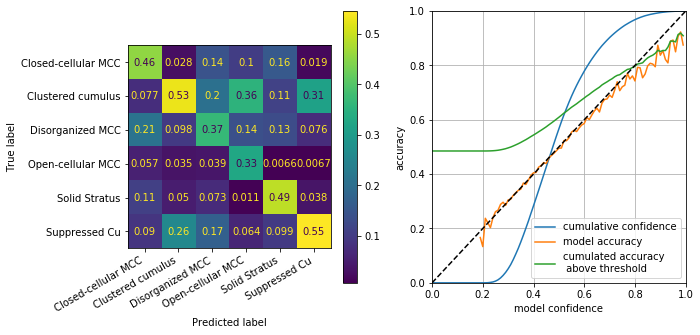

In [86]:
#model calibration
probs = rf.predict_proba(rot_norm_pcs_test)
max_probs = np.max(probs, axis=1)
true = test_cats
preds = rf.predict(rot_norm_pcs_test)
confs = np.arange(0,1,0.01)
cum_confs = np.zeros_like(confs)
mean_scores = np.zeros_like(confs)
gt_scores = np.zeros_like(confs)
for i,c in enumerate(confs):
    where_conf = np.logical_and(max_probs>c, max_probs<(c+np.diff(confs)[2]))
    where_gt_conf = max_probs>c
    mean_scores[i] =np.sum(preds[where_conf]==true[where_conf])/np.sum(where_conf)
    gt_scores[i] = np.sum(preds[where_gt_conf]==true[where_gt_conf])/np.sum(where_gt_conf)
    cum_confs[i] = np.sum(max_probs<c)/len(max_probs)

fig, [ax1, ax2] = plt.subplots(figsize=(10, 5), ncols=2)
plot_confusion_matrix(rf, rot_norm_pcs_test, y_true=test_cats, display_labels=[labels[i] for i in rf.classes_],
                     normalize='pred', xticks_rotation=30, ax=ax1)
ax1.set_xticklabels([i.get_text() for i in ax1.get_xticklabels()], ha='right')
ax2.plot(confs, cum_confs, label='cumulative confidence')
ax2.plot(confs, mean_scores, label='model accuracy')
ax2.plot(confs, gt_scores, label='cumulated accuracy \n above threshold')
ax2.plot((0,1),(0,1),'--k')
ax2.set_xlabel('model confidence')
ax2.set_ylabel('accuracy')
ax2.set_xlim((0,1))
ax2.set_ylim((0,1))
ax2.grid(True)
ax2.legend()
# fig.savefig('/home/disk/p/jkcm/plots/dissertation/model_performance.png', bbox_inches='tight')

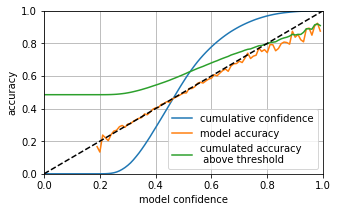

In [87]:
fig, ax2 = plt.subplots(figsize=(5, 3))
# plot_confusion_matrix(rf, rot_norm_pcs_test, y_true=test_cats, display_labels=[labels[i] for i in rf.classes_],
#                      normalize='pred', xticks_rotation=30, ax=ax1)
# ax1.set_xticklabels([i.get_text() for i in ax1.get_xticklabels()], ha='right')
ax2.plot(confs, cum_confs, label='cumulative confidence')
ax2.plot(confs, mean_scores, label='model accuracy')
ax2.plot(confs, gt_scores, label='cumulated accuracy \n above threshold')
ax2.plot((0,1),(0,1),'--k')
ax2.set_xlabel('model confidence')
ax2.set_ylabel('accuracy')
ax2.set_xlim((0,1))
ax2.set_ylim((0,1))
ax2.grid(True)
ax2.legend()
fig.savefig('/home/disk/p/jkcm/plots/defense/rf_calibration.png', bbox_inches='tight')

In [88]:
precision, recall, fscore, support = precision_recall_fscore_support(true, preds)
weight = support/sum(support)

In [89]:
fscore

array([0.47567144, 0.55399268, 0.40096686, 0.18635002, 0.48037693,
       0.48900462])

In [42]:
np.sum(fscore*weight)

0.542501330701957

In [43]:
# this is a second model, trained with the regular unscaled, un-PCA'd training data
rf_npc = RandomForestClassifier(**rf_params)
# Train the model on training data
rf_npc.fit(train_features, train_cats)
#model accuracy per category
print("NON-PCA model test results:")
for i in np.unique(test_cats):
    arr = test_cats==i
    test_features_i = test_data[arr]
    test_cats_i = test_cats[arr]
    sc = rf_npc.score(test_features_i, test_cats_i)
    print(f'score for {labels[i]}:      {sc:0.0%}')
    
sc = rf_npc.score(test_data, test_cats)
print(f'\nOverall score:      {sc:0.0%}')

NON-PCA model test results:
score for Closed-cellular MCC:      48%
score for Clustered cumulus:      65%
score for Disorganized MCC:      48%
score for Open-cellular MCC:      13%
score for Solid Stratus:      42%
score for Suppressed Cu:      72%

Overall score:      58%


In [44]:
pd.concat([train_subset,test_subset],ignore_index=True)

,MERRA2_sfc_div,MERRA2_div_700,MERRA2_SST,MERRA2_EIS,MERRA2_LTS,MERRA2_RH_700,MERRA2_WSPD_10M,MERRA2_PS,MERRA2_TQV,MERRA2_T2M,MERRA2_M,MERRA2_T_adv,MERRA2_T_700,amsr_tb_rate,low_cf,cat,lat,lon,cert
0,6.113951e-06,-4.675650e-06,283.300171,4.169738,10.533195,0.182541,8.776658,101768.476562,9.822736,281.234009,-2.052391,-4.967008e-05,261.514221,0.007898,0.628214,1.0,-47.555672,278.445862,0.992219
1,-1.468586e-06,-3.165991e-06,282.548218,3.561621,9.379517,0.207733,8.783848,101664.476562,9.520001,280.909790,-2.141815,-3.268507e-05,260.388580,0.008976,0.749777,1.0,-48.681293,278.699150,0.746200
2,-1.292175e-06,-1.200826e-06,294.499390,5.078611,18.711845,0.428162,4.549530,102236.476562,32.494610,293.900024,-12.106339,9.378330e-06,280.489166,0.017421,0.364624,1.0,-29.540600,274.781113,0.989267
3,2.963682e-06,-9.736924e-07,293.944702,6.040057,19.076218,0.487366,4.409870,102136.476562,30.924299,293.657837,-12.450912,3.811805e-06,280.772369,0.000445,0.132751,5.0,-29.318108,276.910767,0.879275
4,2.501598e-06,-1.354697e-06,293.657593,6.224375,19.413010,0.454468,4.165299,102070.476562,30.125471,293.355103,-12.324265,5.869026e-06,280.834869,0.000240,0.126770,5.0,-29.123333,278.552307,0.999915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423461,3.838134e-07,-4.106600e-06,301.256470,-1.268181,12.109390,0.362427,6.522226,101290.414062,35.606640,299.666382,-4.926132,-8.597201e-07,280.111328,0.033635,0.427751,1.0,-11.166769,228.117966,0.999930
423462,-1.209243e-06,-1.591123e-06,301.225220,-1.338541,12.376099,0.496948,5.555031,101322.414062,37.184765,299.299194,-4.755386,-6.394615e-06,279.939453,0.023204,0.482849,1.0,-11.000389,229.287521,0.999950
423463,-9.665646e-06,6.965165e-07,301.010376,-0.825023,12.698860,0.562866,5.004216,101310.414062,38.098827,299.248413,-4.957176,-9.153652e-06,280.271484,0.028543,0.593939,1.0,-10.827164,230.475922,0.999079
423464,-1.242740e-05,1.767856e-06,300.795532,0.008458,13.736786,0.388733,4.988837,101322.414062,37.755077,298.904663,-5.025253,-3.454716e-06,280.861328,0.037504,0.314046,1.0,-10.631310,231.784805,0.999996


In [45]:
# adding in classifications and saving
subset_df_all = pd.concat([train_subset,test_subset],ignore_index=True)
probs_train = rf.predict_proba(rot_norm_pcs_all)
max_probs_train = np.max(probs_train, axis=1)
preds_train = rf.predict(rot_norm_pcs_all)
probs_test = rf.predict_proba(rot_norm_pcs_test)
max_probs_test = np.max(probs_test, axis=1)
preds_test = rf.predict(rot_norm_pcs_test)
max_probs_all = np.hstack([max_probs_train, max_probs_test])
preds_all = np.hstack([preds_train, preds_test])
subset_df_all['rf_prob'] = max_probs_all
subset_df_all['rf_pred'] = preds_all
pickle.dump(subset_df_all, open(f'/home/disk/eos4/jkcm/Data/MEASURES/models/rf_ver1_classified_data.pickle', "wb" ))



# Part 3: Feature importance, Partial Dependencies

In [107]:
# feat_import_npc = permutation_importance(rf_npc, test_data, test_cats, n_jobs=8)
feat_import = permutation_importance(rf, rot_norm_pcs_test, test_cats, n_repeats=10, n_jobs=8)

In [108]:
def feature_importance_by_category(model, test_features, test_cats):
    cat_dict = {}
    for i in np.unique(test_cats):
        arr = test_cats==i
        test_features_i = test_features[arr]
        test_cats_i = test_cats[arr]
        pfi = permutation_importance(model, test_features_i, test_cats_i, n_jobs=4)
        cat_dict[i] = pfi
    return cat_dict
# feat_import_npc_by_cat = feature_importance_by_category(rf_npc, test_features, test_cats)
feat_import_by_cat = feature_importance_by_category(rf, rot_norm_pcs_test, test_cats)


/home/disk/p/jkcm/anaconda3/envs/classified-cset/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


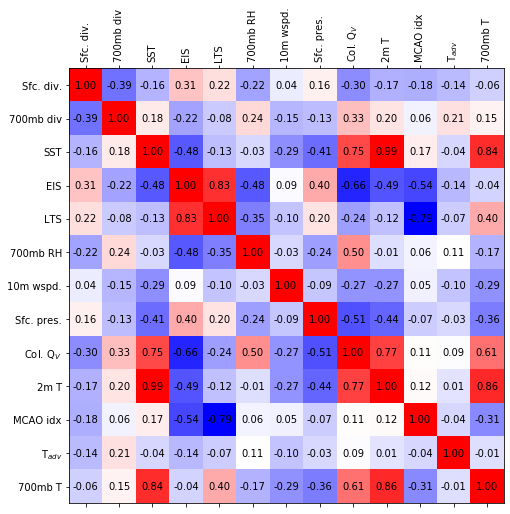

In [109]:
# arr = np.isin(train_labels, [1,5])
# x = np.corrcoef(x_train[arr].T)
fig, ax = show_matrix(np.corrcoef(x_train.T))
ax.set_yticks(np.arange(13))
ax.set_yticklabels(var_labels)
ax.set_xticks(np.arange(13))
ax.set_xticklabels(var_labels, rotation=90)
fig.savefig('/home/disk/p/jkcm/plots/defense/raw_correlations.png', bbox_inches='tight')

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7faa2c98c850>)

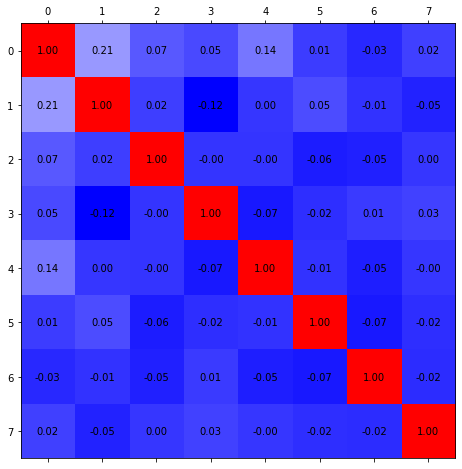

In [110]:
arr = np.isin(test_cats, [1,5])
x = np.corrcoef(rot_norm_pcs_test[arr].T)
show_matrix(x)

In [111]:
arr = np.isin(test_cats, [1, 5])
cu_feat_import = permutation_importance(rf,  rot_norm_pcs_test[arr], test_cats[arr], n_repeats=10, n_jobs=8)

In [112]:
arr = np.isin(test_cats, [0, 3])
mcc_feat_import = permutation_importance(rf,  rot_norm_pcs_test[arr], test_cats[arr], n_repeats=10, n_jobs=8)

In [42]:
def plot_pfi(pfi, labs, title='', ax=None):
    if not ax:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure
    means = pfi['importances_mean']*100
    stds = pfi['importances_std']*100
    ax.barh(range(len(means)), means, xerr=stds, align='center')
    ax.set_yticks(np.arange(len(means)))
    ax.set_yticklabels(labs)
    ax.set_xlabel("Feature importance (accuracy drop)")
#     ax.set_label("Feature")
    ax.set_ylim(-1, len(means))
    ax.set_title(title)
    ax.invert_yaxis()
    ax.grid(axis='x')
    ax.set_xticklabels([f'{i:0.0f}%' for i in ax.get_xticks()])
    return fig, ax
cols = ['"temperature"', '"stability"', '"l.s. subs."', '"windiness"', '"moisture"', '"warm adv."', 
        '"surface div."', '"surface pres."']
# cols = ['"temperature"', '"stability"', '"l.s. subs."', '"windiness"', '"moisture"', '"warm adv."', '"prcp. rate"', 
#         '"surface div."', '"surface pres."']
# cols = ['"temperature"', '"stability"', '"moisture"', '"windiness"', '"warm adv."', '"l.s. subs."', '"surface pres."']
# fig_npc, ax_npc = plot_pfi(feat_import_npc, vars_to_use, 'raw permutation feature importance (no PCA)')

NameError: name 'plot_pfi' is not defined

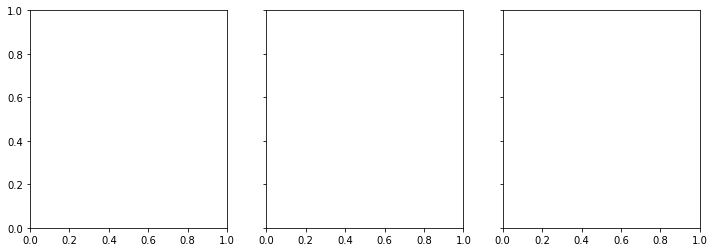

In [41]:
fig, [ax1, ax2, ax3] = plt.subplots(figsize=(12,4), ncols=3, sharey=True)
plot_pfi(feat_import, [f'PC{i+1} ({cols[i]})' for i in range(k)], 'a) Rotated PCA feature importance', ax=ax1)
plot_pfi(cu_feat_import, [f'PC{i+1} ({cols[i]})' for i in range(k)], 'b) Suppressed vs. Clustered only', ax=ax2)
plot_pfi(mcc_feat_import, [f'PC{i+1} ({cols[i]})' for i in range(k)], 'c) Open MCC vs. Closed MCC only', ax=ax3)
# ax1.yaxis.tick_right()
fig.subplots_adjust(wspace=0.1)
# fig.savefig('/home/disk/p/jkcm/plots/dissertation/feature_importance.png', bbox_inches='tight')


# fig, ax = plot_pfi(mcc_feat_import, [f'PC{i+1} ({cols[i]})' for i in range(k)], 'MCC-only feature import')

In [ ]:
#PFI maps
#for each variable, shuffle it
#run the dataset with shuffled variable through the model and get a prediction set
#

In [418]:
x_test = rot_norm_pcs_test
y_test = test_cats
y_pred = rf.predict(x_test)
model = rf
var_names = cols
lat = test_subset['lat'].values
lon = test_subset['lon'].values
seas_old = test_subset['season'].values
b, seas = np.unique(seas_old, return_inverse=True)
lat_round = np.round(lat/4)*4
lon_round = np.round(lon/4)*4
ilats = np.unique(lat_round)
ilons = np.unique(lon_round)
template_arr = np.full((len(ilats), len(ilons)), fill_value=np.nan)
dict_of_shuffled_preds = {i: template_arr.copy() for i,_ in enumerate(var_names)}
base_acc = template_arr.copy()

In [321]:
for var_i, name in enumerate(var_names):    
    x_test_randi = x_test.copy()

    for i,ilat in enumerate(ilats):
        for j,ilon in enumerate(ilons):
            print(f'\r{(i*len(ilons)+j)/(len(ilons)*len(ilats)):%}', end='')
            idx = np.logical_and(lat_round==ilat, lon_round==ilon)
            x_test_randi[idx, var_i] = np.random.permutation(x_test_randi[idx, var_i])

        shuffle_pred = rf.predict(x_test_randi)
    model_gotitright = y_pred == y_test
            
            
            
#             if sum(idx)==0:
#                 base_acc[i,j] = np.nan
#                 continue
#             y_pred_i = rf.predict(x_test[idx])
#             y_true = test_cats[idx]
#             acc = np.sum(y_pred_i==y_true)
#             base_acc[i, j] = acc

UsageError: Line magic function `%lprun` not found.


In [370]:
x_test_randi.shape

(197295, 8)

In [367]:
a = np.array([1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4])
b = np.array([i*10 for i in a])
c = np.array([i*100 for i in a])
d = np.array([1,2,3,4]*4)
d = np.array([10,11,12,13,20,21,22,23,30,31,32,33,40,41,42,43])
r = np.vstack([a,b,c,d])

In [368]:
r[3,a==1] = np.random.permutation(r[3,a==1])

In [369]:
r

array([[  1,   1,   1,   1,   2,   2,   2,   2,   3,   3,   3,   3,   4,
          4,   4,   4],
       [ 10,  10,  10,  10,  20,  20,  20,  20,  30,  30,  30,  30,  40,
         40,  40,  40],
       [100, 100, 100, 100, 200, 200, 200, 200, 300, 300, 300, 300, 400,
        400, 400, 400],
       [ 11,  13,  12,  10,  20,  21,  22,  23,  30,  31,  32,  33,  40,
         41,  42,  43]])

KeyboardInterrupt: 

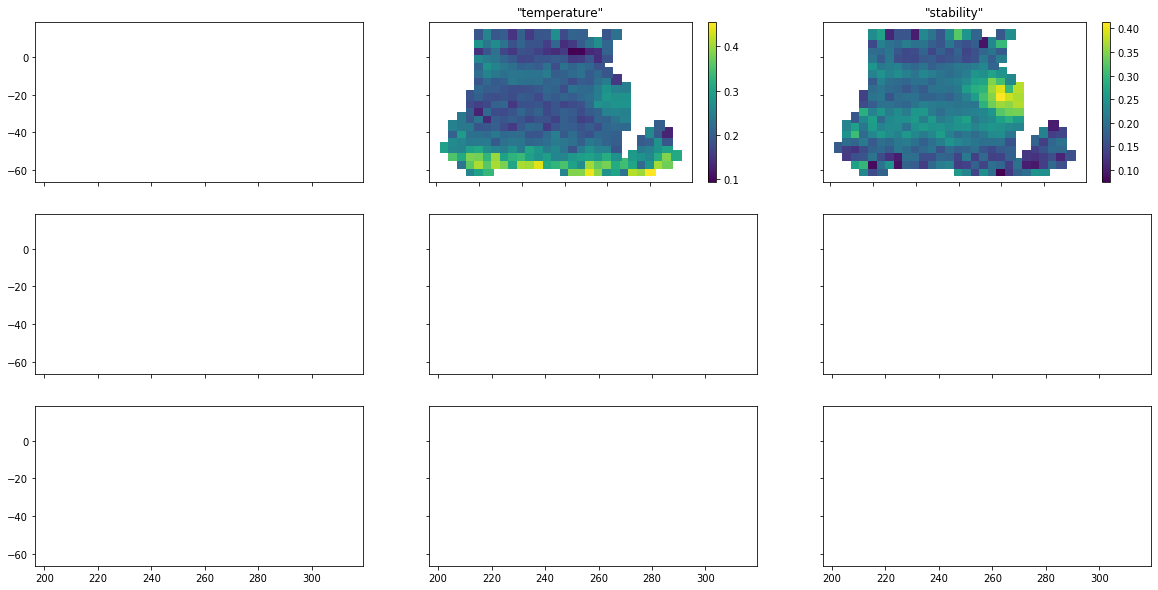

In [419]:
fig, ax = plt.subplots(figsize=(20,10), nrows=3, ncols=3, sharex=True, sharey=True)
axn = ax.flatten()[1:]

for i, name in enumerate(var_names):
    var = i # testing on temp
    x_test_randi = x_test.copy()
    np.random.shuffle(x_test_randi[:,var])
    shuffle_pred = rf.predict(x_test_randi)
    model_gotitright = y_pred == y_test
    lat_round = np.round(lat/4)*4
    lon_round = np.round(lon/4)*4
    df = pd.DataFrame({'lat':lat_round, 'lon':lon_round, 
                       'y_test': y_test, 'y_pred':y_pred, 'shuffle_pred':shuffle_pred})
    df['model_gotitright'] = df['y_pred'] == df['y_test']
    df['shuffled_gotitright'] = df['shuffle_pred'] == df['y_test']
    df['model_lostskill'] = df['model_gotitright'] & ~df['shuffled_gotitright']
    grouped = df.groupby(['lat', 'lon']).mean()
    count = df.groupby(['lat', 'lon']).count()
    grouped.loc[count['y_test']<30] = np.nan
    rlat, rlon = zip(*grouped.index.values)
    sc = axn[i].scatter(rlon, rlat, c=grouped['model_lostskill'].values, s=100, marker='s')#, vmax=0.3)
    plt.colorbar(sc, ax=axn[i])
    axn[i].set_title(name)
    
sc = ax[0,0].scatter(rlon, rlat, c=grouped['model_gotitright'].values, s=100, marker='s')#, vmax=0.3)
plt.colorbar(sc, ax=ax[0,0])
ax[0,0].set_title('base model accuracy')


    #showing, for each gridbox, the fraction of correctly classified scenes which are subsequently
    # misclassified when that variable is shuffled

In [413]:
np.unique(seas)

array(['DJF', 'JJA', 'MAM', 'SON'], dtype=object)

/home/disk/p/jkcm/Code/classified_cset/utils.py:417: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  ax=ax, resolution='l', **kwargs)
/home/disk/p/jkcm/Code/classified_cset/utils.py:417: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  ax=ax, resolution='l', **kwargs)
/home/disk/p/jkcm/Code/classified_cset/utils.py:417: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  ax=ax, resolution='l', **kwargs)
/home/disk/p/jkcm/Code/classified_cset/utils.py:417: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  ax=ax, resolution='l', **kwargs)
/home/disk/p/jkcm/Code/classified_cset/utils.py:417: MatplotlibDeprecationWarnin

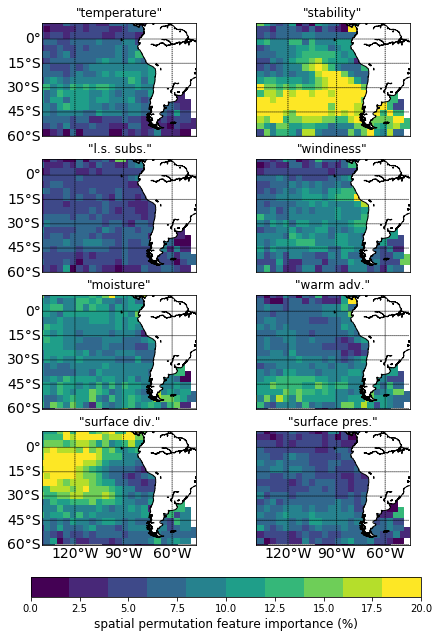

In [421]:
fig, ax = plt.subplots(figsize=(7,12), nrows=4, ncols=2, sharex=True, sharey=True)
axn = ax.flatten()#[1:]
llr = {'lat':(-60,10), 'lon':(220,315)}
# ax[0,0].set_xlim(220, 300)
# ax[0,0].set_ylim(-50, 10)

for i, name in enumerate(var_names):
    var = i # testing on temp
    x_test_randi = x_test.copy()
#     np.random.shuffle(x_test_randi[:,var])
    for j,ilat in enumerate(ilats):
        for k,ilon in enumerate(ilons):
            for l,iseas in enumerate(np.unique(seas)):
    #             print(f'\r{(j*len(ilons)+k)/(len(ilons)*len(ilats)):%}', end='')
                idx = np.logical_and(np.logical_and(lat_round==ilat, lon_round==ilon), seas==iseas)
                x_test_randi[idx, i] = np.random.permutation(x_test_randi[idx, i])

    shuffle_pred = rf.predict(x_test_randi)
    model_gotitright = y_pred == y_test
    lat_round = np.round(lat/4)*4
    lon_round = np.round(lon/4)*4
    df = pd.DataFrame({'lat':lat_round, 'lon':lon_round, 
                       'y_test': y_test, 'y_pred':y_pred, 'shuffle_pred':shuffle_pred})
    df['model_gotitright'] = df['y_pred'] == df['y_test']
    df['shuffled_gotitright'] = df['shuffle_pred'] == df['y_test']
    df['model_lostskill'] = df['model_gotitright'] & ~df['shuffled_gotitright']
    grouped = df.groupby(['lat', 'lon']).mean()
    count = df.groupby(['lat', 'lon']).count()
    grouped.loc[count['y_test']<30] = np.nan
    rlat, rlon = zip(*grouped.index.values)
    par_labs = [1, 0, 0, 0] if i%2 ==0 else [0, 0, 0, 0]
    mer_labs = [0, 0, 0, 1] if i in [6,7] else [0, 0, 0, 0]
    b = utils.bmap(ax=axn[i], llr=llr, par_labs=par_labs, mer_labs=mer_labs, merspace=30)    
    sc = b.scatter(rlon, rlat, c=grouped['model_lostskill'].values*100, s=100, marker='s',
                       vmin=0, vmax=20)#, vmax=0.3)

    axn[i].set_title(name)

cb = plt.colorbar(sc, ax=ax, orientation='horizontal', pad=0.05)
cb.set_label(label='spatial permutation feature importance (%)', size=12)
    
# b = utils.bmap(ax=ax[0,0], llr=llr, par_labs=[1, 0, 0, 0] , mer_labs=[0]*4, merspace=30)    
# sc = b.scatter(rlon, rlat, c=grouped['model_gotitright'].values*100, s=100, marker='s', cmap='plasma')
# plt.colorbar(sc, ax=ax[0,0], label='base model accuracy (5)', orientation='horizontal')
# # ax[0,0].set_title('base model accuracy')

fig.savefig('/home/disk/p/jkcm/plots/dissertation/spatial_permutation_feature_importance.png', bbox_inches='tight')


    #showing, for each gridbox, the fraction of correctly classified scenes which are subsequently
    # misclassified when that variable is shuffled

/home/disk/p/jkcm/Code/classified_cset/utils.py:417: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  ax=ax, resolution='l', **kwargs)
/home/disk/p/jkcm/Code/classified_cset/utils.py:417: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  ax=ax, resolution='l', **kwargs)
/home/disk/p/jkcm/Code/classified_cset/utils.py:417: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  ax=ax, resolution='l', **kwargs)
/home/disk/p/jkcm/Code/classified_cset/utils.py:417: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  ax=ax, resolution='l', **kwargs)
/home/disk/p/jkcm/Code/classified_cset/utils.py:417: MatplotlibDeprecationWarnin

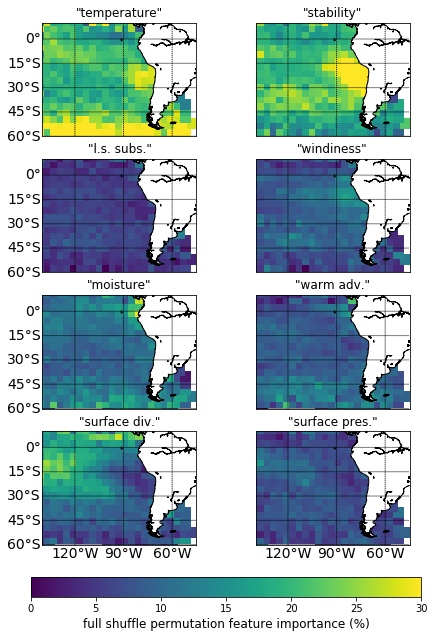

In [401]:
fig, ax = plt.subplots(figsize=(7,12), nrows=4, ncols=2, sharex=True, sharey=True)
axn = ax.flatten()#[1:]
llr = {'lat':(-60,10), 'lon':(220,315)}
# ax[0,0].set_xlim(220, 300)
# ax[0,0].set_ylim(-50, 10)

for i, name in enumerate(var_names):
    var = i # testing on temp
    x_test_randi = x_test.copy()
    np.random.shuffle(x_test_randi[:,var])
#     for j,ilat in enumerate(ilats):
#         for k,ilon in enumerate(ilons):
# #             print(f'\r{(j*len(ilons)+k)/(len(ilons)*len(ilats)):%}', end='')
#             idx = np.logical_and(lat_round==ilat, lon_round==ilon)
#             x_test_randi[idx, i] = np.random.permutation(x_test_randi[idx, i])

    shuffle_pred = rf.predict(x_test_randi)
    model_gotitright = y_pred == y_test
    lat_round = np.round(lat/4)*4
    lon_round = np.round(lon/4)*4
    df = pd.DataFrame({'lat':lat_round, 'lon':lon_round, 
                       'y_test': y_test, 'y_pred':y_pred, 'shuffle_pred':shuffle_pred})
    df['model_gotitright'] = df['y_pred'] == df['y_test']
    df['shuffled_gotitright'] = df['shuffle_pred'] == df['y_test']
    df['model_lostskill'] = df['model_gotitright'] & ~df['shuffled_gotitright']
    grouped = df.groupby(['lat', 'lon']).mean()
    count = df.groupby(['lat', 'lon']).count()
    grouped.loc[count['y_test']<30] = np.nan
    rlat, rlon = zip(*grouped.index.values)
    par_labs = [1, 0, 0, 0] if i%2 ==0 else [0, 0, 0, 0]
    mer_labs = [0, 0, 0, 1] if i in [6,7] else [0, 0, 0, 0]
    b = utils.bmap(ax=axn[i], llr=llr, par_labs=par_labs, mer_labs=mer_labs, merspace=30)    
    sc = b.scatter(rlon, rlat, c=grouped['model_lostskill'].values*100, s=100, marker='s',
                       vmin=0, vmax=30)#, vmax=0.3)

    axn[i].set_title(name)

cb = plt.colorbar(sc, ax=ax, orientation='horizontal', pad=0.05)
cb.set_label(label='full shuffle permutation feature importance (%)', size=12)
    
# b = utils.bmap(ax=ax[0,0], llr=llr, par_labs=[1, 0, 0, 0] , mer_labs=[0]*4, merspace=30)    
# sc = b.scatter(rlon, rlat, c=grouped['model_gotitright'].values*100, s=100, marker='s', cmap='plasma')
# plt.colorbar(sc, ax=ax[0,0], label='base model accuracy (5)', orientation='horizontal')
# # ax[0,0].set_title('base model accuracy')

fig.savefig('/home/disk/p/jkcm/plots/dissertation/full_shuffle_permutation_feature_importance.png', bbox_inches='tight')


    #showing, for each gridbox, the fraction of correctly classified scenes which are subsequently
    # misclassified when that variable is shuffled

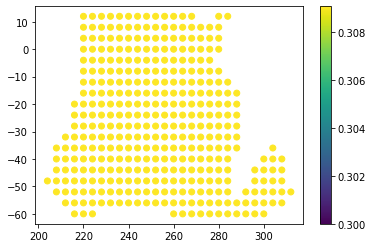

In [263]:
rlat, rlon = zip(*grouped.index.values)
plt.scatter(rlon, rlat, c=grouped['model_gotitright'].values, vmax=0.3)
plt.colorbar()
#showing, for each gridbox, the fraction of correctly classified scenes which are subsequently
# misclassified when that variable is shuffled

In [127]:
np.sum(y_test==y_pred)/len(y_pred)

0.47447730555766743

In [128]:
np.sum(y_test==shuffle_pred)/len(shuffle_pred)

0.43272764134924857

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

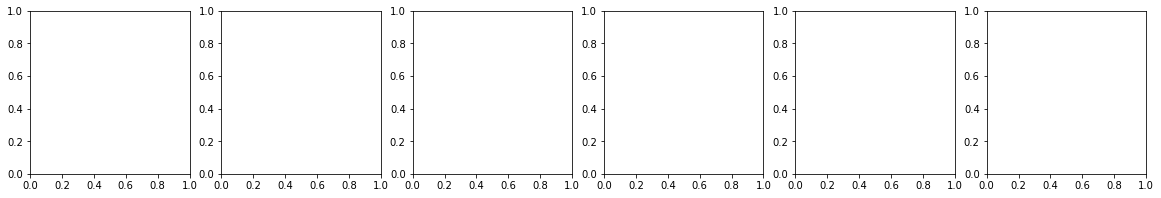

In [176]:
fig, ax = plt.subplots(ncols=6, figsize=(20,3))
for axi, key in zip(ax, list(feat_import_by_cat.keys())):
    plot_pfi(feat_import_by_cat[key]['importances_mean'], [f'PC{i+1}' for i in range(k)], labels[int(key)], ax=axi)
for axi in ax:
    axi.grid(True)
    axi.set_xlim((0, 0.15))

NameError: name 'feat_import_npc_by_cat' is not defined

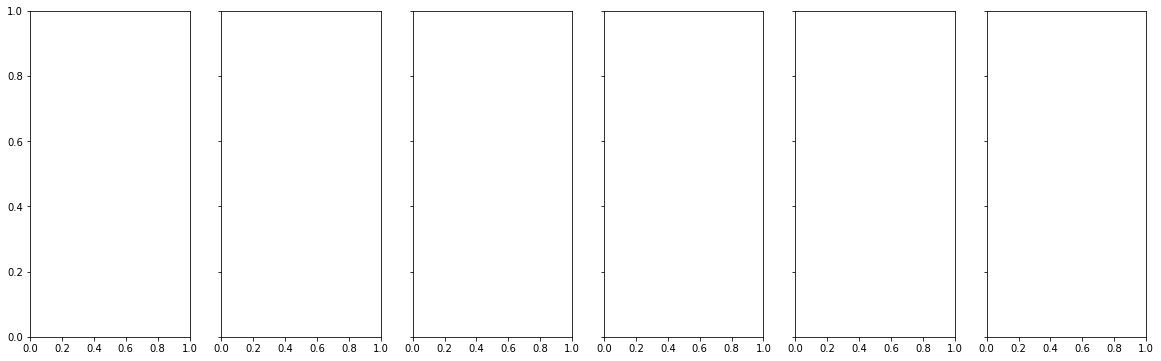

In [177]:
fig, ax = plt.subplots(ncols=6, figsize=(20,6), sharey=True)
for axi, key in zip(ax, list(feat_import_by_cat.keys())):
    plot_pfi(feat_import_npc_by_cat[key]['importances_mean'], [i[7:] for i in vars_to_use], labels[int(key)], ax=axi)
for axi in ax:
    axi.grid(True)
    axi.set_xlim((0, 0.2))

In [18]:
model_save_dict = dict(
    model=rf,
    x_test = rot_norm_pcs_test,
    x_train = rot_norm_pcs,
    loadings =rot_loadings,
    pct_var = pct_var,
    pct_var_rot = pct_var_rot)

pickle.dump(model_save_dict, open(f'/home/disk/eos4/jkcm/Data/MEASURES/models/simple_rf_pca_model.pickle', "wb" ))


In [19]:
# This is a very computationally intensive calculation, and should be batched out and done on a separate node, to avoid clogging the main fileserver

for target in rf.classes_:
    break
#     pdp = plot_partial_dependence(rf, rot_norm_pcs_test, features=[0, 1, 2, 3, 4, 5, 6, 7], feature_names=[f'PC{i+1}' for i in range(loadings.shape[0])], 
#                             target=target, verbose=True, n_jobs=4)
    pdp_2d = plot_partial_dependence(rf, rot_norm_pcs_test, features=[(0,1), (0,4), (2,6)], feature_names=[f'PC{i+1}' for i in range(loadings.shape[0])], 
                            target=target, verbose=True, n_jobs=4)
    pickle.dump(pdp, open(f'/home/disk/eos4/jkcm/Data/MEASURES/pdp/ver1_pdp_target_2d_{target}.pickle', "wb" ))

# for target in rf.classes_

# Part 4: What if we did a regression instead?

In [20]:
from sklearn import linear_model
lm = linear_model.LinearRegression()
model = lm.fit(rot_norm_pcs,train_labels)
lm.score(rot_norm_pcs_test,test_labels)

# predictions = lm.predict(X)
# print(predictions)[0:5]

0.33391864429931506

In [21]:
rf_r_params = dict(
    n_estimators=50,
    criterion='mse',
    min_samples_leaf=2,
    max_features='auto',
    n_jobs=16,
    random_state=10,
    max_samples=0.5,
)

In [100]:
rf_r = RandomForestRegressor(**rf_r_params)
rf_r.fit(rot_norm_pcs, train_labels)
print("PCA regression on low CF:")
# for i in np.unique(val_cats):
#     arr = val_cats == i
#     val_features_i = rot_norm_pcs_val[arr]
#     val_labels_i = val_labels[arr]
#     sc = rf_r.score(val_features_i, val_labels_i)
#     freq_of_type = np.sum(arr)/len(arr)
#     print(f'score for {labels[i]} ({freq_of_type:0.0%}):      {sc:0.2}')

sc = rf_r.score(rot_norm_pcs_val, val_labels)
print(f'\Val score:      {sc:0.2}')

sc = rf_r.score(rot_norm_pcs_test, test_labels)
print(f'\nOverall score:      {sc:0.2}')

# sc = rf_r.score(rot_norm_pcs, train_labels)
# print(f'\nTraining score:      {sc:0.0%}')
# if True:
#     scores = cross_val_score(rf_r, x_all, y_data, cv=3)
#     scores

PCA regression on low CF:
\Val score:      0.44

Overall score:      0.36


In [24]:
cols = ['"temperature"', '"stability"', '"l.s. subs."', '"windiness"', '"moisture"', '"warm adv."', 
        '"surface div."', '"surface pres."']

In [107]:
from scipy.stats import linregress
def r_val(df, colname):
    _,_,r,_,_ = linregress(df['y_test'], df[colname])
    return r**2

model = rf_r
x_test = rot_norm_pcs_test
y_test = test_labels
y_pred = model.predict(x_test)
var_names = cols
lat = test_subset['lat'].values
lon = test_subset['lon'].values
seas_old = test_subset['season'].values
b, seas = np.unique(seas_old, return_inverse=True)
lat_round = np.round(lat/4)*4
lon_round = np.round(lon/4)*4
ilats = np.unique(lat_round)
ilons = np.unique(lon_round)
template_arr = np.full((len(ilats), len(ilons)), fill_value=np.nan)
dict_of_shuffled_preds = {i: template_arr.copy() for i,_ in enumerate(var_names)}
base_acc = template_arr.copy()

In [102]:
feat_import = permutation_importance(rf_r, rot_norm_pcs_test, test_labels, n_repeats=10, n_jobs=8)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f296d7ce890>)

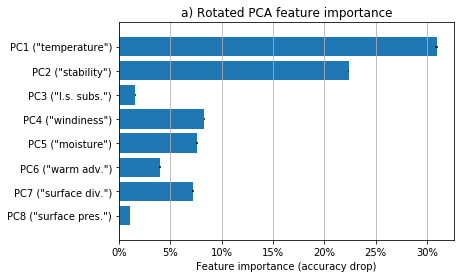

In [103]:
plot_pfi(feat_import, [f'PC{i+1} ({cols[i]})' for i in range(8)], 'a) Rotated PCA feature importance')

/home/disk/p/jkcm/Code/classified_cset/utils.py:417: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  ax=ax, resolution='l', **kwargs)


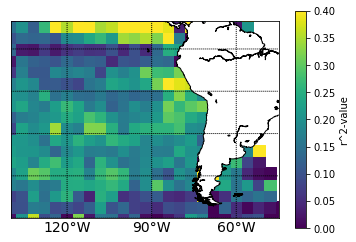

In [108]:
df = pd.DataFrame({'lat':lat_round, 'lon':lon_round, 
                   'y_test': y_test, 'y_pred':y_pred})    
grouped = df.groupby(['lat', 'lon'])
r_good = grouped.apply(r_val, colname='y_pred')
b = utils.bmap(llr=llr, par_labs=par_labs, mer_labs=mer_labs, merspace=30)    
sc = b.scatter(rlon, rlat, c=r_good.values, s=132, marker='s', vmax=0.4)
plt.colorbar(sc, label='r^2-value')

/home/disk/p/jkcm/Code/classified_cset/utils.py:417: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  ax=ax, resolution='l', **kwargs)
/home/disk/p/jkcm/Code/classified_cset/utils.py:417: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  ax=ax, resolution='l', **kwargs)
/home/disk/p/jkcm/Code/classified_cset/utils.py:417: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  ax=ax, resolution='l', **kwargs)
/home/disk/p/jkcm/Code/classified_cset/utils.py:417: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  ax=ax, resolution='l', **kwargs)
/home/disk/p/jkcm/Code/classified_cset/utils.py:417: MatplotlibDeprecationWarnin

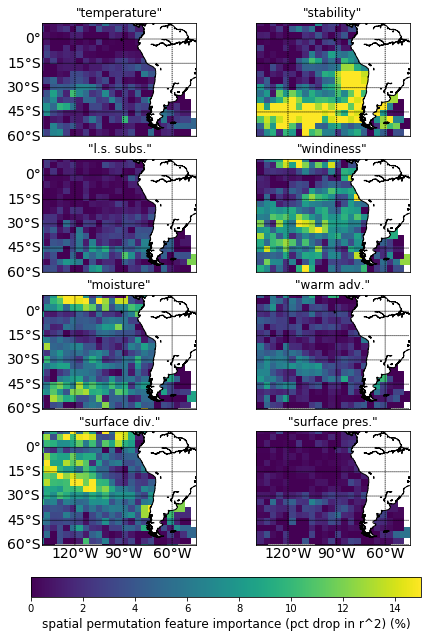

In [114]:

fig, ax = plt.subplots(figsize=(7,12), nrows=4, ncols=2, sharex=True, sharey=True)
axn = ax.flatten()#[1:]
llr = {'lat':(-60,10), 'lon':(220,315)}
# ax[0,0].set_xlim(220, 300)
# ax[0,0].set_ylim(-50, 10)

lat_round = np.round(lat/4)*4
lon_round = np.round(lon/4)*4
df_main = pd.DataFrame({'lat':lat_round, 'lon':lon_round, 
                       'y_test': y_test, 'y_pred':y_pred, 'shuffle_pred':shuffle_pred})
grouped = df.groupby(['lat', 'lon'])
r_good = grouped.apply(r_val, colname='y_pred')


for i, name in enumerate(var_names):
    var = i # testing on temp
    x_test_randi = x_test.copy()
#     np.random.shuffle(x_test_randi[:,var])
    for j,ilat in enumerate(ilats):
        for k,ilon in enumerate(ilons):
            for l,iseas in enumerate(np.unique(seas)):
    #             print(f'\r{(j*len(ilons)+k)/(len(ilons)*len(ilats)):%}', end='')
                idx = np.logical_and(np.logical_and(lat_round==ilat, lon_round==ilon), seas==iseas)
                x_test_randi[idx, i] = np.random.permutation(x_test_randi[idx, i])

    shuffle_pred = model.predict(x_test_randi)
    lat_round = np.round(lat/4)*4
    lon_round = np.round(lon/4)*4
    df = pd.DataFrame({'lat':lat_round, 'lon':lon_round, 
                       'y_test': y_test, 'y_pred':y_pred, 'shuffle_pred':shuffle_pred})
#     df['model_gotitright'] = np.abs(df['y_pred'] - df['y_test'])
#     df['shuffled_gotitright'] = np.abs(df['shuffle_pred'] - df['y_test'])
#     df['model_lostskill'] = df['shuffled_gotitright'] - df['model_gotitright']
#     model.lostskill = 
    
    grouped = df.groupby(['lat', 'lon'])
    count = df.groupby(['lat', 'lon']).count()
#     r_good = grouped.apply(r_val, colname='y_pred')
    r_shuf = grouped.apply(r_val, colname='shuffle_pred')
    lost_skill = (r_good-r_shuf)
    lost_skill.loc[count['y_test']<30] = np.nan

    rlat, rlon = zip(*r_good.index.values)
    par_labs = [1, 0, 0, 0] if i%2 ==0 else [0, 0, 0, 0]
    mer_labs = [0, 0, 0, 1] if i in [6,7] else [0, 0, 0, 0]
    b = utils.bmap(ax=axn[i], llr=llr, par_labs=par_labs, mer_labs=mer_labs, merspace=30)    
    sc = b.scatter(rlon, rlat, c=lost_skill.values*100, s=100, marker='s',
                       vmin=0, vmax=15)#, vmax=0.3)

    axn[i].set_title(name)
    
#     if i > 2:
#         break

cb = plt.colorbar(sc, ax=ax, orientation='horizontal', pad=0.05)
cb.set_label(label='spatial permutation feature importance (pct drop in r^2) (%)', size=12)
    
# b = utils.bmap(ax=ax[0,0], llr=llr, par_labs=[1, 0, 0, 0] , mer_labs=[0]*4, merspace=30)    
# sc = b.scatter(rlon, rlat, c=grouped['model_gotitright'].values*100, s=100, marker='s', cmap='plasma')
# plt.colorbar(sc, ax=ax[0,0], label='base model accuracy (5)', orientation='horizontal')
# # ax[0,0].set_title('base model accuracy')

# fig.savefig('/home/disk/p/jkcm/plots/dissertation/spatial_permutation_feature_importance.png', bbox_inches='tight')


    #showing, for each gridbox, the fraction of correctly classified scenes which are subsequently
    # misclassified when that variable is shuffled

In [78]:
cats = np.concatenate([rot_norm_pcs_all, y_data[:,None]], axis=1)


In [82]:
pd.to_dataframe(cats)

AttributeError: module 'pandas' has no attribute 'to_dataframe'

In [26]:
corr = train_subset[train_subset.lat>-50].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,MERRA2_sfc_div,MERRA2_div_700,MERRA2_SST,MERRA2_EIS,MERRA2_LTS,MERRA2_RH_700,MERRA2_WSPD_10M,MERRA2_PS,MERRA2_TQV,MERRA2_T2M,MERRA2_M,MERRA2_T_adv,MERRA2_T_700,low_cf,cat,lat
MERRA2_sfc_div,1.00,-0.41,-0.15,0.31,0.22,-0.23,0.03,0.16,-0.30,-0.16,-0.18,-0.16,-0.03,-0.09,0.09,-0.11
MERRA2_div_700,-0.41,1.00,0.18,-0.22,-0.09,0.25,-0.15,-0.14,0.33,0.20,0.08,0.22,0.13,0.03,0.02,0.15
MERRA2_SST,-0.15,0.18,1.00,-0.44,-0.11,0.03,-0.24,-0.50,0.74,0.99,0.14,0.00,0.82,-0.40,0.17,0.87
MERRA2_EIS,0.31,-0.22,-0.44,1.00,0.84,-0.53,0.06,0.42,-0.65,-0.46,-0.55,-0.17,0.04,0.32,-0.20,-0.40
MERRA2_LTS,0.22,-0.09,-0.11,0.84,1.00,-0.37,-0.11,0.19,-0.25,-0.10,-0.79,-0.09,0.45,0.30,-0.14,-0.05
MERRA2_RH_700,-0.23,0.25,0.03,-0.53,-0.37,1.00,-0.07,-0.24,0.56,0.05,0.08,0.10,-0.14,0.09,0.04,0.13
MERRA2_WSPD_10M,0.03,-0.15,-0.24,0.06,-0.11,-0.07,1.00,-0.08,-0.24,-0.21,0.06,-0.13,-0.24,0.21,-0.11,-0.19
MERRA2_PS,0.16,-0.14,-0.50,0.42,0.19,-0.24,-0.08,1.00,-0.55,-0.54,-0.05,-0.04,-0.43,0.18,-0.12,-0.64
MERRA2_TQV,-0.30,0.33,0.74,-0.65,-0.25,0.56,-0.24,-0.55,1.00,0.76,0.11,0.12,0.56,-0.19,0.13,0.75
MERRA2_T2M,-0.16,0.20,0.99,-0.46,-0.10,0.05,-0.21,-0.54,0.76,1.00,0.09,0.05,0.83,-0.40,0.18,0.88


# A very simple model

In [20]:
vars_to_use = ['MERRA2_sfc_div', 'MERRA2_div_700', 'MERRA2_SST', 'MERRA2_EIS', 'MERRA2_LTS', 'MERRA2_RH_700', 
               'MERRA2_WSPD_10M', 'MERRA2_PS', 'MERRA2_TQV', 'MERRA2_T2M', 'MERRA2_M', 'MERRA2_T_adv', 'MERRA2_T_700']  # these are the variables to train on
train_subset = all_sep_df[vars_to_use + ['low_cf', 'cat', 'lat']].copy()  # including two different y variables.
train_subset.loc[np.abs(train_subset['MERRA2_T_adv'].values*86400)>5, 'MERRA2_T_adv'] = np.nan
train_subset = train_subset.dropna(axis='index')

labels={0: 'Closed-cellular MCC', 1: 'Clustered cumulus', 2: 'Disorganized MCC',
        3: 'Open-cellular MCC', 4: 'Solid Stratus', 5: 'Suppressed Cu'}

subset_categories = [0,3]
if subset_categories:
    train_subset = train_subset[[i in subset_categories for i in train_subset['cat']]]
    labels = {k: v for k, v in labels.items() if k in subset_categories}
    
train_subset = train_subset[train_subset.lat>-30]
    
    
subset_vars = vars_to_use; ['MERRA2_EIS', 'MERRA2_T_700']
subset_labels = var_labels;['EIS', 'T$_{700}$']
    # Split the data into training and validation sets - since we have a separate test set, we can look at these all we want.
x_data = train_subset[subset_vars].values.copy()
y_data = train_subset['low_cf'].values.copy()
strat_data = train_subset['cat'].values.copy()  # this is the stratification variable - lets make sure we have the right amount of each category in both datasets.
simple_train_features, simple_test_features, simple_train_labels, simple_test_labels, simple_train_cats, simple_test_cats = train_test_split(
    x_data, y_data, strat_data, test_size = 0.25, random_state = 42, stratify=strat_data)

/home/disk/p/jkcm/anaconda3/envs/classified-cset/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


In [21]:
# model for the PC-transformed data
dtc = DecisionTreeClassifier(max_depth=3, splitter='best', class_weight='balanced')
# Train the model on training data
dtc.fit(simple_train_features, simple_train_cats)
#model accuracy per category
print("decision tree model:")
for i in np.unique(simple_test_cats):
    arr = simple_test_cats==i
    test_features_i = simple_test_features[arr]
    test_cats_i = simple_test_cats[arr]
    sc = dtc.score(test_features_i, test_cats_i)
    freq_of_type = np.sum(arr)/len(arr)
    print(f'score for {labels[i]} ({freq_of_type:0.0%}):      {sc:0.0%}')
    
sc = dtc.score(simple_test_features, simple_test_cats)
print(f'\nOverall score:      {sc:0.0%}')

if False:
    scores = cross_val_score(rf, x_all, strat_data, cv=5)

decision tree model:
score for Closed-cellular MCC (78%):      71%
score for Open-cellular MCC (22%):      75%

Overall score:      72%


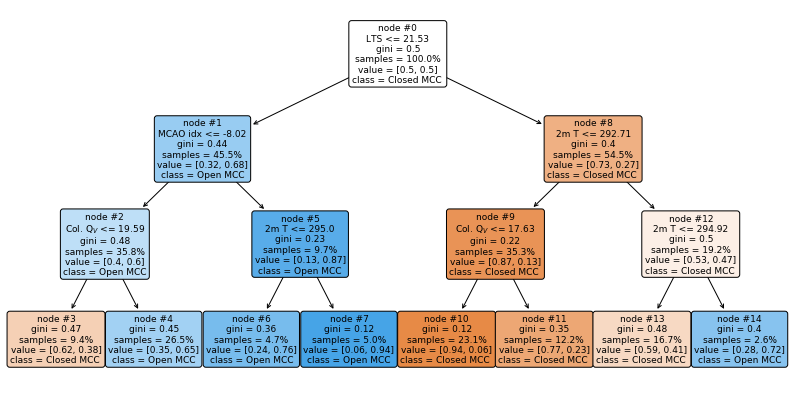

In [40]:
fig, ax = plt.subplots(figsize=(14,7))

plot_tree(dtc,
          feature_names = subset_labels, 
          class_names=[short_labels[i] for i in dtc.classes_],
          rounded=True,
          proportion=True,
          precision=2,
          node_ids=True,
          filled = True, ax=ax);
fig.savefig('/home/disk/p/jkcm/plots/dissertation/sample_decision_tree.png', bbox_inches='tight')

# Aside: CCA

In [128]:
from sklearn.cross_decomposition import CCA
X = x_all
Y = y_data
cca = CCA(n_components=1)
cca.fit(X, Y)
X_c, Y_c = cca.transform(X, Y)

In [122]:
X_c2 = np.matmul(X, cca.x_weights_)

In [132]:
cca.score(X,)

-6.840172012288013

In [133]:
cca.score(x_test, test_labels)

0.2209189546587309

In [135]:
x_test_c = np.matmul(x_test, cca.x_weights_)

In [139]:
np.corrcoef(x_test_c[:,0], test_labels)[0][1]**2

0.38104740963221295

In [125]:
X_c-X_c2

array([[1.87515729e-04],
       [9.53179080e-05],
       [1.30895018e-05],
       ...,
       [2.82193393e-04],
       [2.55335806e-04],
       [2.41674246e-04]])

In [116]:
X.shape

(305089, 13)

0.2209189546587309

In [118]:
X_c.shape

(305089, 1)

In [94]:
cca.x_loadings_

array([[ 0.49532554],
       [-0.12392827],
       [ 3.02110283],
       [-2.39069012],
       [-2.01268852],
       [-0.79673379],
       [-1.58505837],
       [-1.16169785],
       [ 1.56887333],
       [ 3.00677202],
       [ 2.0395103 ],
       [ 0.75538559],
       [ 1.71320467]])

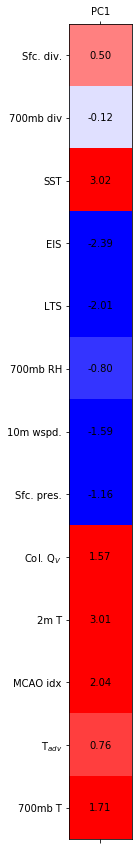

In [97]:
# Plotting Loadings from CCA
fig, ax = plt.subplots(figsize=(7,15), ncols=1)
show_loadings(cca.x_loadings_.T, var_labels, ax=ax, vmin=-1, vmax=1)
# show_loadings(rot_loadings.T, var_labels, ax=ax2, vmin=-1, vmax=1)
# ax1.set_title('Principal Component Loadings')
# ax1.axvline(7.5, c='k', ls='--')
# ax2.axvline(7.5, c='k', ls='--')
# ax2.set_title('Rotated Loadings')
# ax1.yaxis.tick_right()
# fig.subplots_adjust(wspace=0.20)
# fig.savefig('/home/disk/p/jkcm/plots/dissertation/ch3_loadings.png', bbox_inches='tight')

In [113]:
np.corrcoef(X_c[:,0], Y_c)[0][1]**2

0.40701346790825227

In [109]:
test_c = 

(305089,)

In [178]:
# Support Vector Machines? Again? Really trying hard for that nostalgia anxiety huh. Nope, fit time too high
# KNN it is!
from sklearn.neighbors import KNeighborsClassifier

In [180]:
knn_params = dict(
    algorithm='kd_tree',
    n_neighbors=10, n_jobs=16)

In [149]:
knn = KNeighborsClassifier(**knn_params)
knn.fit(rot_norm_pcs, train_cats)

print("PCA KNN model:")
for i in np.unique(val_cats):
    arr = val_cats==i
    val_features_i = rot_norm_pcs_val[arr]
    val_cats_i = val_cats[arr]
    sc = knn.score(val_features_i, val_cats_i)
    freq_of_type = np.sum(arr)/len(arr)
    print(f'score for {labels[i]} ({freq_of_type:0.0%}):      {sc:0.0%}')
    
sc = knn.score(rot_norm_pcs_val, val_cats)
print(f'\nOverall score:      {sc:0.0%}')

sc = knn.score(rot_norm_pcs, train_cats)
print(f'\nTraining score:      {sc:0.0%}')
if False:
    scores = cross_val_score(rf, x_all, strat_data, cv=5)

PCA KNN model:
score for Closed-cellular MCC (12%):      56%
score for Clustered cumulus (32%):      62%
score for Disorganized MCC (19%):      44%
score for Open-cellular MCC (3%):      11%
score for Solid Stratus (10%):      39%
score for Suppressed Cu (24%):      45%

Overall score:      50%

Training score:      59%


In [182]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

In [184]:
hgb = HistGradientBoostingClassifier(max_iter=100).fit(rot_norm_pcs, train_cats)
hgb.score(rot_norm_pcs_val, val_cats)

0.5169325973804623

In [185]:
hgb.score(rot_norm_pcs_test, test_cats)

0.4911427050862921

In [186]:

print("PCA HistGBC model:")
for i in np.unique(test_cats):
    arr = test_cats==i
    test_features_i = rot_norm_pcs_test[arr]
    test_cats_i = test_cats[arr]
    sc = hgb.score(test_features_i, test_cats_i)
    freq_of_type = np.sum(arr)/len(arr)
    print(f'score for {labels[i]} ({freq_of_type:0.0%}):      {sc:0.0%}')

sc = hgb.score(rot_norm_pcs_test, test_cats)
print(f'\nOverall score:      {sc:0.0%}')

# sc = hgb.score(rot_norm_pcs, train_cats)
# print(f'\nTraining score:      {sc:0.0%}')

PCA HistGBC model:
score for Closed-cellular MCC (12%):      47%
score for Clustered cumulus (32%):      62%
score for Disorganized MCC (17%):      44%
score for Open-cellular MCC (3%):      7%
score for Solid Stratus (10%):      41%
score for Suppressed Cu (26%):      45%

Overall score:      49%


In [ ]:
# Extra Random Tree model for the PC-transformed data
rf_extra = ExtraTreesClassifier(**rf_params)
# Train the model on training data
rf_extra.fit(rot_norm_pcs, train_cats)
print("ExtraTrees PCA model validation:")
test_model(rf_extra)

sc = rf_extra.score(rot_norm_pcs_test, test_cats)
print(f'\nTraining score:      {sc:0.0%}')

In [169]:
# what if we just used a classifier to predict cloud fraction???
rf_params = dict(
    n_estimators = 100, 
    random_state = 43, 
    n_jobs=12, 
    max_features='auto',
    min_samples_leaf=2,
    class_weight='balanced_subsample')

rf = RandomForestClassifier(**rf_params)
rf.fit(rot_norm_pcs, train_cats_cf)
sc = rf.score(rot_norm_pcs, train_cats_cf)
print(f'\nTraining score:      {sc:0.0%}\n')
print('validation results:')
print(classification_report(val_cats_cf,  rf.predict(rot_norm_pcs_val), digits=2, labels=ordering, target_names=[labels[i] for i in ordering]))
print('test results:')
# print(classification_report(test_cats_cf, rf.predict(rot_norm_pcs_test), digits=2, labels=ordering, target_names=[labels[i] for i in ordering]))


Training score:      100%

validation results:
                     precision    recall  f1-score   support

      Solid Stratus       0.31      0.27      0.29     12689
Closed-cellular MCC       0.41      0.52      0.46     12829
   Disorganized MCC       0.27      0.21      0.24     12782
  Open-cellular MCC       0.29      0.23      0.25     12757
  Clustered cumulus       0.30      0.28      0.29     12476
      Suppressed Cu       0.52      0.69      0.59     12740

           accuracy                           0.37     76273
          macro avg       0.35      0.37      0.35     76273
       weighted avg       0.35      0.37      0.35     76273

test results:


In [181]:
knn = KNeighborsClassifier(**knn_params)
knn.fit(rot_norm_pcs, train_cats_cf)


sc = knn.score(rot_norm_pcs_val, val_cats_cf)
print(f'\nOverall score:      {sc:0.0%}')

sc = knn.score(rot_norm_pcs_test, test_cats_cf)
print(f'\nTraining score:      {sc:0.0%}')


Overall score:      34%

Training score:      30%


In [131]:
print(rot_norm_pcs_all.shape)
train_subset.shape
preds = rf.predict(rot_norm_pcs_all)
train_subset['preds'] = preds

test_preds = rf.predict(rot_norm_pcs_test)
test_subset['preds'] = test_preds

(305089, 8)


In [132]:
plot_df = test_subset
from matplotlib import colors
import utils


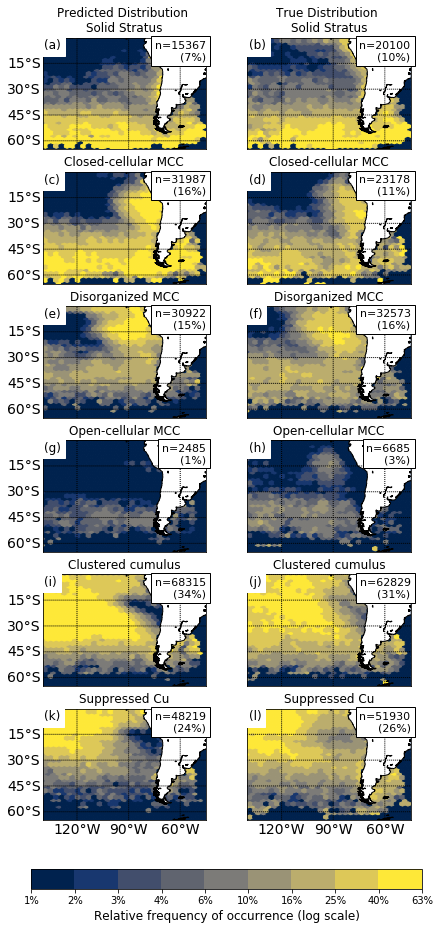

In [152]:
llr = {'lat':(-65,0), 'lon':(220,315)}
ticks = np.logspace(-2, 0, 11)[:-1]
bnorm = colors.BoundaryNorm(boundaries=ticks, ncolors=256)
lnorm = colors.LogNorm(vmin=0.01, vmax=0.7)

fig, ax = plt.subplots()
b = utils.bmap(ax=ax, llr=llr)
image = b.hexbin(plot_df['lon'], plot_df['lat'], gridsize=30, extent=(*llr['lon'], *llr['lat']))
all_counts = image.get_array()+1
plt.close()



fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(7,18), sharex=True, sharey=True)
axn = ax[:,0].flatten()
for cat, name  in utils.labels.items():
    axi = axn[utils.ordering.index(cat)]
    df_sub = plot_df[plot_df['preds']==cat]
    par_labs = [1, 0, 0, 0]
    mer_labs = [0, 0, 0, 1] if cat in [5] else [0, 0, 0, 0]
    b = utils.bmap(ax=axi, llr=llr, par_labs=par_labs, mer_labs=mer_labs, merspace=30)

    image = b.hexbin(df_sub['lon'], df_sub['lat'], gridsize=30, extent=(*llr['lon'], *llr['lat']), norm=bnorm, cmap='cividis')
    normed_counts = image.get_array()/all_counts
    normed_counts[all_counts==1] = np.nan
    image.set_array(normed_counts)
    nstr = f"n={sum(df_sub['preds']==cat)}\n({int(sum(df_sub['preds']==cat)*100/len(plot_df))}%)"
    axi.set_title(name)
    axi.annotate(nstr, xy=(1, 0.8), xycoords='axes fraction', fontsize=11, c='k', ha='right', bbox={'facecolor': 'w', 'edgecolor': 'k'})
# cb = plt.colorbar(image, ax=axn, ticks=ticks, orientation='horizontal', pad=0.1)
# cb.set_ticklabels([f"{i:0.0%}" for i in ticks])
# cb.set_label("Relative frequency of occurrence (log scale)", fontsize=12)
ax[0,0].set_title('Predicted Distribution \n' +ax[0,0].get_title());



axn = ax[:,1].flatten()
for cat, name  in utils.labels.items():
    axi = axn[utils.ordering.index(cat)]
    df_sub = plot_df[plot_df['cat']==cat]
    par_labs = [0, 0, 0, 0]
    mer_labs = [0, 0, 0, 1] if cat in [5] else [0, 0, 0, 0]
    b = utils.bmap(ax=axi, llr=llr, par_labs=par_labs, mer_labs=mer_labs, merspace=30)

    image = b.hexbin(df_sub['lon'], df_sub['lat'], gridsize=30, extent=(*llr['lon'], *llr['lat']), norm=bnorm, cmap='cividis')
    normed_counts = image.get_array()/all_counts
    normed_counts[all_counts==1] = np.nan
    image.set_array(normed_counts)
    nstr = f"n={sum(df_sub['cat']==cat)}\n({int(sum(df_sub['cat']==cat)*100/len(plot_df))}%)"
    axi.set_title(name)
    axi.annotate(nstr, xy=(1, 0.8), xycoords='axes fraction', fontsize=11, c='k', ha='right', bbox={'facecolor': 'w', 'edgecolor': 'k'})

# add_labels(axn)    
for i, axi in enumerate(ax.flatten()):
    axi.text(0.01, 0.99, f"({chr(ord('a') + i)})", fontsize=12, backgroundcolor='w',
             horizontalalignment='left', verticalalignment='top', transform=axi.transAxes)

plt.subplots_adjust(hspace=0.2, wspace=0.1)

cb = plt.colorbar(image, ax=ax, ticks=ticks, orientation='horizontal', pad=0.05)
cb.set_ticklabels([f"{i:0.0%}" for i in ticks])
cb.set_label("Relative frequency of occurrence (log scale)", fontsize=12)
ax[0,1].set_title('True Distribution \n' +ax[0,1].get_title());
fig.savefig('/home/disk/p/jkcm/plots/dissertation/map_comparison.png', bbox_inches='tight')


# fig.savefig('/home/disk/p/jkcm/plots/measures/final/SEP_classifications_map.png', bbox_inches='tight')

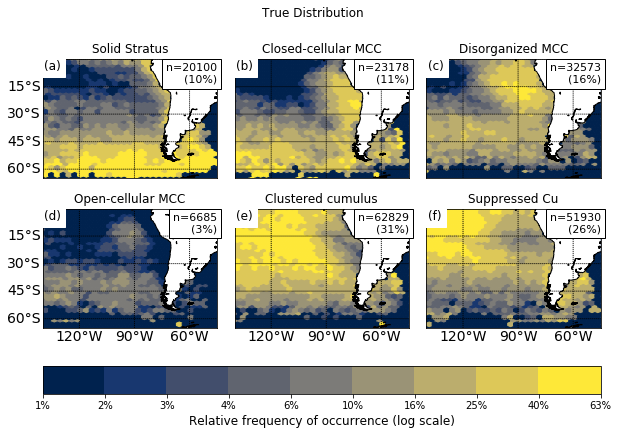

In [143]:
ax[1,1].get_title()

'Closed-cellular MCC'